In [1]:
import re
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch as th
import torch.autograd as ag
import torch.nn.functional as F
import torch.nn as nn

# Deep Learning for NLP - lab exercise 1

In this first lab exercise we will implement a simple bag-of-word classifier, i.e. a classifier that ignores the sequential structure of the sentence. The goal is to predict if a sentence is a positive or negative review of a movie. We will use a dataset constructed from IMDB.

1. Load and clean the data
2. Preprocess the data for the NN
3. Module definition
4. Train the network!

We will implement this model with Pytorch, the most popular deep learning framework for Natural Language Processing. You can use the following links for help:
* turorials: http://pytorch.org/tutorials/
* documentation: http://pytorch.org/docs/master/ 

**Hard deadline**: December 3, 2019


## Report

On top of this notebook, you must submit a report explaining your neural network, it's training method and report+analyse results, for example with different hyper-parameters (number of hidden layers, different embedding size, different hidden representation size, w or w/o dropout...you choose what you want to explore!).
You can also report results with different training dataset sizes (how does the number of training instances impact dev/test results? => *WARNING* obviously, here you change the training set size but you freeze the dev/test sets).

Training with the full dataset may be slow depending on your computer.

## Data

The data can be download here: http://teaching.caio-corro.fr/2019-2020/OPT7/imdb.zip

There are two files: one with positive reviews (imdb.pos) and one with negative reviews (imdb.neg). Each file contains 300000 reviews, one per line.


The following functions can be used to load and clean the data.

In [2]:
# Tokenize a sentence
def clean_str(string, tolower=True):
    """
    Tokenization/string cleaning.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    if tolower:
        string = string.lower()
    return string.strip()


# reads the content of the file passed as an argument.
# if limit > 0, this function will return only the first "limit" sentences in the file.
def loadTexts(filename, limit=-1):
    f = open(filename)
    dataset=[]
    line =  f.readline()
    cpt=1
    skip=0
    while line :
        cleanline = clean_str(f.readline()).split()
        if cleanline: 
            dataset.append(cleanline)
        else: 
            line = f.readline()
            skip+=1
            continue
        if limit > 0 and cpt >= limit: 
            break
        line = f.readline()
        cpt+=1        
        
    f.close()
    print("Load ", cpt, " lines from ", filename , " / ", skip ," lines discarded")
    return dataset


The following cell load the first 5000 sentences in each review set.

In [3]:
LIM=5000
txtfile = "./Data/imdb.pos"  # path of the file containing positive reviews
postxt = loadTexts(txtfile,limit=LIM)

txtfile = "./Data/imdb.neg"  # path of the file containing negative reviews
negtxt = loadTexts(txtfile,limit=LIM)

Load  5000  lines from  ./Data/imdb.pos  /  1  lines discarded
Load  5000  lines from  ./Data/imdb.neg  /  1  lines discarded


In [4]:
postxt[:10]

[['do', "n't", 'miss', 'it', 'if', 'you', 'can'],
 ['dreams', 'of', 'a', 'young', 'girl'],
 ['funny', 'funny', 'movie', '!'],
 ['pride', 'and', 'prejudice', 'is', 'absolutely', 'amazing', '!', '!'],
 ['quirky', 'and', 'effective'],
 ['mike', 'leigh', "'s", 'best', 'and', 'the', 'best', 'of', '2010'],
 ['an', 'experience', 'unmatched', 'in', 'film'],
 ['if',
  'john',
  'woo',
  'were',
  'to',
  'of',
  'filmed',
  'the',
  'wizard',
  'of',
  'oz',
  'on',
  'the',
  'set',
  'of',
  'the',
  'wild',
  'bunch'],
 ['it',
  'has',
  'its',
  'shortcomings',
  ',',
  'and',
  'i',
  'presume',
  'the',
  'book',
  'would',
  'be',
  'much',
  'better',
  'but',
  'it',
  'is',
  'still',
  'well',
  'worth',
  'watching'],
 ['csi', 'meets', 'the', 'x', 'files']]

Split the data between train / dev / test, for example by creating lists txt_train, label_train, txt_dev, ... You should take care to keep a 50/50 ratio between positive and negative instances in each set.

In [5]:
# A label of 1 means that the review is positive, 0 means negative

label_pos = [1. for i in range(len(postxt))]
label_neg = [0. for i in range(len(negtxt))]

In [6]:
trainset = postxt + negtxt
labels = label_pos + label_neg

test_size = 0.2
dev_size = 0.2

X_traindev, X_test, y_traindev, y_test = train_test_split(trainset,
                                                         labels,
                                                         test_size=test_size,
                                                         random_state=42,
                                                         stratify=labels)

X_train, X_dev, y_train, y_dev = train_test_split(X_traindev,
                                                  y_traindev,
                                                  test_size=dev_size/(1-test_size),
                                                  random_state=42,
                                                  stratify=y_traindev)    

In [7]:
X_train[:10]

[['far', 'and', 'away', ',', 'the', 'best', 'of', 'the', 'draculas', '!'],
 ['hg', 'wells', 'in', 'name', 'alone'],
 ['horrible'],
 ['what', 'the', 'hell', '!', '!', '!'],
 ['not',
  'quite',
  'a',
  'classic',
  ',',
  'but',
  'worth',
  'the',
  'watch',
  'all',
  'the',
  'same'],
 ['avatar', 'pocahontas', 'in', 'space'],
 ['blah', 'fest', '2003'],
 ['worst', 'cooper', 'movie', 'ever'],
 ['boring', ',', 'inaccurate', ',', 'uninspired'],
 ['a', 'great', 'hammer', 'film', 'even', 'without', 'christopher', 'lee']]

In [8]:
y_train[:10]

[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]

# Converting data to Pytorch tensors

We will first convert data to Pytorch tensors so they can be used in a neural network.
To do that, you must first create a dictionnary that will map words to integers.
Add to the dictionnary only words that are in the training set (be sure to understand why we do that!).

Then, you can convert the data to tensors:
- use tensors of longs: both the sentence and the label will be represented as integers, not floats!
- these tensors do not require a gradient

A tensor representing a sentence is composed of the integer representation of each word, e.g. [10, 256, 3, 4].
Note that some words in the dev and test sets may not be in the dictionnary! (i.e. unknown words)
You can just skip them.

In [9]:
vocab_size = 0
dictionary = {}
for i in range(len(X_train)):
    for j in range(len(X_train[i])):
        if X_train[i][j] not in dictionary:
            dictionary[X_train[i][j]] = vocab_size
            vocab_size += 1

In [10]:
def transform_to_tensor(data, dictionary):
    Tnsr = []        
    for item in data:
        if item in dictionary.keys():
            Tnsr.append(dictionary[item]) 
    return th.tensor(Tnsr)

# Neural network definition

The neural network should be defined as follows:
- it takes as input a tensor that is a sequence of integers indexing word embeddings
- it retrieves the word embeddings from an embedding table
- it constructs the "input" of the MLP by summing over all embeddings (i.e. bag-of-word model)
- it build a hidden represention using a MLP (1 layer? 2 layers? experiment! but maybe first try wihout any hidden layer...)
- it project the hidden representation to the output space: it is a binary classification task, so the output space is a scalar where a negative (resp. positive) value means the review is negative (resp. positive).

In [11]:
class CBOW_classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW_classifier, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 1)
        
        # TODO
        # To create an embedding table: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        
    def forward(self, inputs):
        out = self.embeddings(inputs).sum(0)
        out = self.linear1(out)
        return out

## Loss function

Create a loss function builder.

- Pytorch loss functions are documented here: https://pytorch.org/docs/stable/nn.html#loss-functions
- In our case, we are interested in *BCELoss* and *BCEWithLogitsLoss*. Read their documentation and choose the one that fits with your network output

In [12]:
BCELogitLoss = th.nn.BCEWithLogitsLoss()

## Training loop

Write your training loop!

- parameterizable number of epochs
- at each epoch, print the mean loss and the dev accuracy

In [13]:
def accuracy(model, 
             X, 
             y, 
             dictionary):
    correct = 0
    total = 0
    for data, label in zip(X, y):
        x = transform_to_tensor(data, dictionary)
        if x.size()[0] <= 0:
            continue
        output = model(x)
        total += 1
        if (output >= 0) == (label == 1.):
            correct += 1
    return correct/total * 100

def train(model, 
          optimizer, 
          loss_function, 
          X, 
          y, 
          X_val, 
          y_val, 
          dictionary):
    cost = 0
    data, label = shuffle(X, y)
    for examp, target in zip(data, label):
        model.zero_grad()
        output = model(transform_to_tensor(examp, dictionary))
        loss = loss_function(output, th.tensor([target]))
        loss.backward()
        optimizer.step()
        cost += loss.item()
    mean_loss = cost / len(y)
    acc = accuracy(model, X_val, y_val, dictionary)
    return mean_loss, acc, model

def training_loop(model, 
                  optimizer, 
                  loss_function, 
                  n_epochs, 
                  X, 
                  y, 
                  X_val, 
                  y_val, 
                  dictionary):
    loss_list = []
    dev_acc_list = []
    for epoch in range(n_epochs):
        print("Starting epoch: {}".format(epoch))
        mean_loss, accuracy, model = train(model, optimizer, loss_function, X, y, X_val, y_val, dictionary)
        
        loss_list.append(mean_loss)
        dev_acc_list.append(accuracy)  

        print('mean loss : ', mean_loss)
        print('accuracy on dev set : ', accuracy)
    return model, loss_list, dev_acc_list

In [14]:
def plot_graphs(mean_losss, 
                dev_accus, 
                embedding_size, 
                n_hidden_layers):
    plt.plot([i for i in range(EPOCHS)],mean_losss, label='mean loss')
    plt.plot([i for i in range(EPOCHS)],dev_accus, label='accuracy on dev')
    plt.xlabel('Epochs')
    plt.title('{} hidden layers, {} embedding_size'.format(n_hidden_layers,
                                                          embedding_size))
    plt.legend()
    plt.savefig('{}HiddenLayer{}.png'.format(n_hidden_layers,
                                            embedding_size))
    plt.show()

Starting epoch: 0
mean loss :  0.6646446105143987
accuracy on dev set :  68.38383838383838
Starting epoch: 1
mean loss :  0.5382456751227049
accuracy on dev set :  71.6161616161616
Starting epoch: 2
mean loss :  0.4581092344222081
accuracy on dev set :  73.98989898989899
Starting epoch: 3
mean loss :  0.40135041453863596
accuracy on dev set :  75.45454545454545
Starting epoch: 4
mean loss :  0.35884676853172753
accuracy on dev set :  76.01010101010101
Starting epoch: 5
mean loss :  0.32475718049379404
accuracy on dev set :  76.61616161616162
Starting epoch: 6
mean loss :  0.29595484268409084
accuracy on dev set :  76.36363636363637
Starting epoch: 7
mean loss :  0.27125733440915867
accuracy on dev set :  76.36363636363637
Starting epoch: 8
mean loss :  0.24976445722179325
accuracy on dev set :  76.66666666666667
Starting epoch: 9
mean loss :  0.23059173055032345
accuracy on dev set :  76.36363636363637


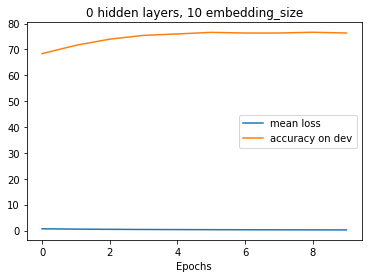

Starting epoch: 0
mean loss :  0.6297645426977324
accuracy on dev set :  73.38383838383838
Starting epoch: 1
mean loss :  0.44379275849375993
accuracy on dev set :  75.75757575757575
Starting epoch: 2
mean loss :  0.3486594397912457
accuracy on dev set :  76.81818181818181
Starting epoch: 3
mean loss :  0.28168389949944017
accuracy on dev set :  76.81818181818181
Starting epoch: 4
mean loss :  0.23917107158562984
accuracy on dev set :  77.62626262626262
Starting epoch: 5
mean loss :  0.20708451145802917
accuracy on dev set :  77.07070707070707
Starting epoch: 6
mean loss :  0.18481955764707492
accuracy on dev set :  77.72727272727272
Starting epoch: 7
mean loss :  0.16374620780162422
accuracy on dev set :  76.76767676767676
Starting epoch: 8
mean loss :  0.14979140897145501
accuracy on dev set :  77.72727272727272
Starting epoch: 9
mean loss :  0.13761190015789024
accuracy on dev set :  76.11111111111111


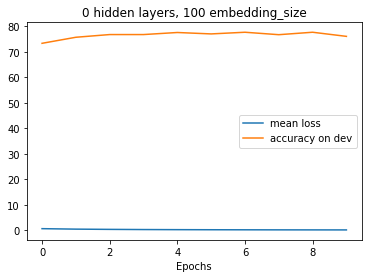

Starting epoch: 0
mean loss :  0.9190783462620993
accuracy on dev set :  74.74747474747475
Starting epoch: 1
mean loss :  0.6865965431835448
accuracy on dev set :  75.35353535353535
Starting epoch: 2
mean loss :  0.5373626720624013
accuracy on dev set :  74.04040404040404
Starting epoch: 3
mean loss :  0.4758327971146648
accuracy on dev set :  77.22222222222223
Starting epoch: 4
mean loss :  0.3952512412659139
accuracy on dev set :  75.80808080808082
Starting epoch: 5
mean loss :  0.382660696512508
accuracy on dev set :  74.24242424242425
Starting epoch: 6
mean loss :  0.3865999062861651
accuracy on dev set :  74.24242424242425
Starting epoch: 7
mean loss :  0.33929588599784477
accuracy on dev set :  76.01010101010101
Starting epoch: 8
mean loss :  0.321762925847692
accuracy on dev set :  75.95959595959596
Starting epoch: 9
mean loss :  0.3012839493939892
accuracy on dev set :  76.01010101010101


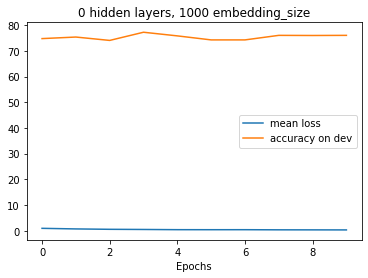

In [17]:
embedding_sizes = [10, 100, 1000]
models_list = []
mean_loss_list = []
dev_accuracy_list = []

EPOCHS = 10
n_hidden_layers = 0

for embedding_size in embedding_sizes:
    model = CBOW_classifier(vocab_size, embedding_size)
    optimizer = th.optim.Adam(model.parameters(),lr=0.001)
    model, mean_losses, dev_accus = training_loop(model, optimizer, BCELogitLoss, EPOCHS, X_train, y_train, X_dev, y_dev, dictionary)
    models_list.append(model)
    mean_loss_list.append(mean_losses)
    dev_accuracy_list.append(dev_accus)
    plot_graphs(mean_losses, dev_accus, embedding_size, n_hidden_layers)

## Layer testing

Now that we have found a value for the embedding size that balances training time and performance (embedding_size = 10), we go on to test different numbers of hidden layers. We test adding one layer and adding two layers. More testing with more layers and a different number of nodes per hidden layer would of course be ideal, but due to time and computational limitations, only these tests are run

In [18]:
class CBOW_classifier1layer(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW_classifier1layer, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, int(embedding_dim/2))
        self.activation_function1 = nn.ReLU()
        self.linear2 = nn.Linear(int(embedding_dim/2), 1)
        
        # TODO
        # To create an embedding table: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        
    def forward(self, inputs):
        out = self.embeddings(inputs).sum(0)
        out = self.linear1(out)
        out = self.activation_function1(out)
        out = self.linear2(out)
        return out

Starting epoch: 0
mean loss :  0.686162488737454
accuracy on dev set :  64.6969696969697
Starting epoch: 1
mean loss :  0.5867020655296316
accuracy on dev set :  71.16161616161617
Starting epoch: 2
mean loss :  0.49460768099261637
accuracy on dev set :  75.05050505050505
Starting epoch: 3
mean loss :  0.4261544833812325
accuracy on dev set :  76.36363636363637
Starting epoch: 4
mean loss :  0.3732033907148538
accuracy on dev set :  76.71717171717172
Starting epoch: 5
mean loss :  0.3284655638311042
accuracy on dev set :  76.46464646464646
Starting epoch: 6
mean loss :  0.29264167626061494
accuracy on dev set :  77.32323232323233
Starting epoch: 7
mean loss :  0.26019156650566
accuracy on dev set :  77.82828282828282
Starting epoch: 8
mean loss :  0.23292821352146315
accuracy on dev set :  77.52525252525253
Starting epoch: 9
mean loss :  0.2061912957417903
accuracy on dev set :  77.72727272727272
Starting epoch: 10
mean loss :  0.18378292041682404
accuracy on dev set :  77.7777777777777

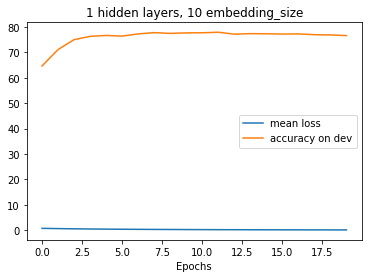

In [19]:
embedding_size = 10
models_list_layertest = []
mean_loss_list_layertest = []
dev_accuracy_list_layertest = []

EPOCHS = 20
n_hidden_layers = 1

model = CBOW_classifier1layer(vocab_size, embedding_size)
optimizer = th.optim.Adam(model.parameters(),lr=0.001)
model, mean_losses, dev_accus = training_loop(model, optimizer, BCELogitLoss, EPOCHS, X_train, y_train, X_dev, y_dev, dictionary)
models_list_layertest.append(model)
mean_loss_list_layertest.append(mean_losses)
dev_accuracy_list_layertest.append(dev_accus)
plot_graphs(mean_losses, dev_accus, embedding_size, n_hidden_layers)

In [20]:
class CBOW_classifier2layer(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW_classifier2layer, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, int(embedding_dim*0.75))
        self.activation_function1 = nn.ReLU()
        self.linear2 = nn.Linear(int(embedding_dim*0.75), int(embedding_dim*0.25))
        self.activation_function2 = nn.ReLU()
        self.linear3 = nn.Linear(int(embedding_dim*0.25), 1)
        
        # TODO
        # To create an embedding table: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        
    def forward(self, inputs):
        out = self.embeddings(inputs).sum(0)
        out = self.linear1(out)
        out = self.activation_function1(out)
        out = self.linear2(out)
        out = self.activation_function2(out)
        out = self.linear3(out)
        return out

Starting epoch: 0
mean loss :  0.6845304183581223
accuracy on dev set :  61.36363636363637
Starting epoch: 1
mean loss :  0.622616349538924
accuracy on dev set :  68.38383838383838
Starting epoch: 2
mean loss :  0.5425428548220007
accuracy on dev set :  71.36363636363636
Starting epoch: 3
mean loss :  0.48001552372827716
accuracy on dev set :  72.32323232323232
Starting epoch: 4
mean loss :  0.43046294947734454
accuracy on dev set :  72.72727272727273
Starting epoch: 5
mean loss :  0.3863574902740824
accuracy on dev set :  73.53535353535354
Starting epoch: 6
mean loss :  0.34937995817082923
accuracy on dev set :  73.68686868686869
Starting epoch: 7
mean loss :  0.31929953962364055
accuracy on dev set :  74.0909090909091
Starting epoch: 8
mean loss :  0.291410885158216
accuracy on dev set :  74.34343434343434
Starting epoch: 9
mean loss :  0.2683189293402826
accuracy on dev set :  74.0909090909091
Starting epoch: 10
mean loss :  0.246297856174177
accuracy on dev set :  73.83838383838383

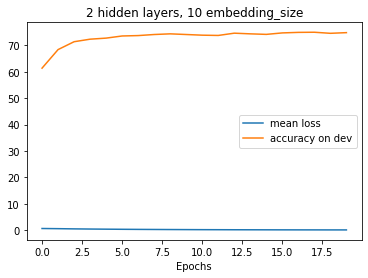

In [21]:
embedding_sizes = 10

EPOCHS = 20
n_hidden_layers = 2

model = CBOW_classifier2layer(vocab_size, embedding_size)
optimizer = th.optim.Adam(model.parameters(),lr=0.001)
model, mean_losses, dev_accus = training_loop(model, optimizer, BCELogitLoss, EPOCHS, X_train, y_train, X_dev, y_dev, dictionary)
models_list_layertest.append(model)
mean_loss_list_layertest.append(mean_losses)
dev_accuracy_list_layertest.append(dev_accus)
plot_graphs(mean_losses, dev_accus, embedding_size, n_hidden_layers)

## Dropout testing

Now that we have found a good number of layers (1) for the network, we can go on and test some dropout values.

In [22]:
class CBOW_classifier1layerdropout(nn.Module):
    def __init__(self, vocab_size, embedding_dim, dropout_value):
        super(CBOW_classifier1layerdropout, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, int(embedding_dim/2))
        self.activation_function1 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_value)
        self.linear2 = nn.Linear(int(embedding_dim/2), 1)
        
        # TODO
        # To create an embedding table: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        
    def forward(self, inputs):
        out = self.embeddings(inputs).sum(0)
        out = self.linear1(out)
        out = self.activation_function1(out)
        out = self.dropout(out)
        out = self.linear2(out)
        return out

Starting epoch: 0
mean loss :  0.6876656130800645
accuracy on dev set :  60.656565656565654
Starting epoch: 1
mean loss :  0.6089951889005024
accuracy on dev set :  69.2929292929293
Starting epoch: 2
mean loss :  0.534057238081942
accuracy on dev set :  71.81818181818181
Starting epoch: 3
mean loss :  0.47114302228410815
accuracy on dev set :  72.42424242424242
Starting epoch: 4
mean loss :  0.4124414532142822
accuracy on dev set :  73.48484848484848
Starting epoch: 5
mean loss :  0.3766396262040649
accuracy on dev set :  75.60606060606061
Starting epoch: 6
mean loss :  0.34003117204773176
accuracy on dev set :  75.35353535353535
Starting epoch: 7
mean loss :  0.31468458551655976
accuracy on dev set :  75.4040404040404
Starting epoch: 8
mean loss :  0.28774452054329436
accuracy on dev set :  75.0
Starting epoch: 9
mean loss :  0.2642974225202347
accuracy on dev set :  75.60606060606061
Starting epoch: 10
mean loss :  0.24397442480029047
accuracy on dev set :  75.9090909090909
Starting 

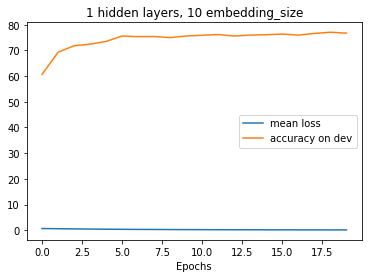

Starting epoch: 0
mean loss :  0.6901081515823801
accuracy on dev set :  58.838383838383834
Starting epoch: 1
mean loss :  0.6317372729321257
accuracy on dev set :  65.7070707070707
Starting epoch: 2
mean loss :  0.5692838327852364
accuracy on dev set :  69.14141414141413
Starting epoch: 3
mean loss :  0.5202975800532841
accuracy on dev set :  70.85858585858585
Starting epoch: 4
mean loss :  0.47448966384521857
accuracy on dev set :  71.86868686868686
Starting epoch: 5
mean loss :  0.4463365314860854
accuracy on dev set :  71.66666666666667
Starting epoch: 6
mean loss :  0.42087834558061543
accuracy on dev set :  73.08080808080808
Starting epoch: 7
mean loss :  0.3984525867237058
accuracy on dev set :  72.82828282828284
Starting epoch: 8
mean loss :  0.3799387746230348
accuracy on dev set :  73.28282828282828
Starting epoch: 9
mean loss :  0.3748042736011274
accuracy on dev set :  71.76767676767678
Starting epoch: 10
mean loss :  0.3513731205266373
accuracy on dev set :  73.78787878787

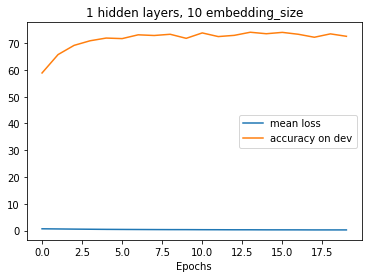

Starting epoch: 0
mean loss :  0.7021538026890096
accuracy on dev set :  55.45454545454545
Starting epoch: 1
mean loss :  0.6716373601546123
accuracy on dev set :  62.62626262626263
Starting epoch: 2
mean loss :  0.6344651420371508
accuracy on dev set :  65.40404040404042
Starting epoch: 3
mean loss :  0.6008773621008576
accuracy on dev set :  65.35353535353535
Starting epoch: 4
mean loss :  0.5777808742480116
accuracy on dev set :  67.07070707070707
Starting epoch: 5
mean loss :  0.5545997766376176
accuracy on dev set :  67.22222222222223
Starting epoch: 6
mean loss :  0.5321212852188367
accuracy on dev set :  67.87878787878789
Starting epoch: 7
mean loss :  0.5216934387317173
accuracy on dev set :  67.82828282828282
Starting epoch: 8
mean loss :  0.5064598542686471
accuracy on dev set :  69.1919191919192
Starting epoch: 9
mean loss :  0.500711462474851
accuracy on dev set :  69.24242424242424
Starting epoch: 10
mean loss :  0.47845397467164935
accuracy on dev set :  68.73737373737374

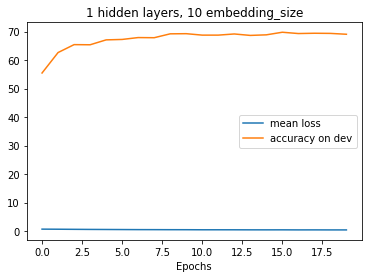

In [23]:
embedding_sizes = 10
models_list_dropout = []
mean_loss_list_dropout = []
dev_accuracy_list_dropout = []
dropout_list = [0.2, 0.5, 0.7]

EPOCHS = 20
n_hidden_layers = 1

for dropout_value in dropout_list:
    model = CBOW_classifier1layerdropout(vocab_size, embedding_size, dropout_value)
    optimizer = th.optim.Adam(model.parameters(),lr=0.001)
    model, mean_losses, dev_accus = training_loop(model, optimizer, BCELogitLoss, EPOCHS, X_train, y_train, X_dev, y_dev, dictionary)
    models_list.append(model)
    mean_loss_list.append(mean_losses)
    dev_accuracy_list.append(dev_accus)
    plot_graphs(mean_losses, dev_accus, embedding_size, n_hidden_layers)